# MRI-based brain tumor detection using EfficientNetB0 pre_trained deep learning model

dataset: https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset


## Load the Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

##  Create New structure
brain_tumor_split/

├── train/

│   ├── brain tumor/

│   ├── healthy/

├── val/

│   ├── brain tumor/

│   ├── healthy/

├── test/

│   ├── brain tumor/

│   ├── healthy/


In [ ]:
import os
import random
import shutil
from pathlib import Path

# مسیر اولیه دیتاست
original_dataset_dir = "/content/drive/MyDrive/datasets/brain_tumor"
# مسیر مقصد برای فولدرهای جدید
base_dir = "/content/drive/MyDrive/datasets/brain_tumor_split"
classes = ["brain_tumor", "healthy"]

# نسبت‌ها
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# ساختن فولدرهای train/val/test
for split in ["train", "val", "test"]:
    for class_name in classes:
        split_path = os.path.join(base_dir, split, class_name)
        os.makedirs(split_path, exist_ok=True)

# انتقال فایل‌ها با تقسیم‌بندی
for class_name in classes:
    source_dir = os.path.join(original_dataset_dir, class_name)
    all_files = os.listdir(source_dir)
    random.shuffle(all_files)

    total = len(all_files)
    train_count = int(total * train_ratio)
    val_count = int(total * val_ratio)

    train_files = all_files[:train_count]
    val_files = all_files[train_count:train_count + val_count]
    test_files = all_files[train_count + val_count:]

    for file_list, split in zip([train_files, val_files, test_files], ["train", "val", "test"]):
        for file_name in file_list:
            src = os.path.join(source_dir, file_name)
            dst = os.path.join(base_dir, split, class_name, file_name)
            shutil.copy2(src, dst)


## Prepare Parameters

In [ ]:
img_size = (224, 224)
batch_size = 32
dataset_path = "/content/drive/MyDrive/datasets/brain_tumor_split"


## Load Data with image_dataset_from_directory




In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_ds = image_dataset_from_directory(
    dataset_path + "/train",
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary'
)

val_ds = image_dataset_from_directory(
    dataset_path + "/val",
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary'
)

test_ds = image_dataset_from_directory(
    dataset_path + "/test",
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary'
)


Found 3152 files belonging to 2 classes.
Found 682 files belonging to 2 classes.
Found 680 files belonging to 2 classes.


## Show 5 Pictures from Dataset

In [ ]:
for data_batch, label_batch in train_ds:
  print('Data Batch Shape:', data_batch.shape)
  print('Label Batch Shape:', label_batch.shape)
  break

Data Batch Shape: (32, 224, 224, 3)
Label Batch Shape: (32, 1)


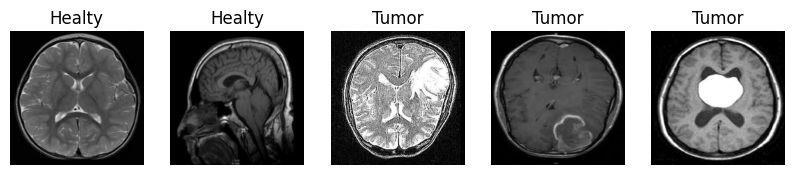

In [ ]:
  fig,axes= plt.subplots(1,5,figsize=(10,3))
  for i,ax in enumerate(axes):
    ax.imshow(data_batch[i].numpy().astype('uint8'))
    ax.set_axis_off()
    ax.set_title('Healty' if label_batch[i].numpy()==1 else 'Tumor')

## Prefetch برای سرعت بیشتر

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

##  Data Augmentation

In [ ]:
data_augmentation =keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

## Model Design

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # فقط feature extraction

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)  # به‌جای Rescaling

x = base_model(x, training=False)  # EfficientNet
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)  # جلوگیری از overfitting
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Model Training

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 419s 4s/step - accuracy: 0.7539 - loss: 0.4900 - val_accuracy: 0.9194 - val_loss: 0.2294
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 49s 133ms/step - accuracy: 0.8888 - loss: 0.2616 - val_accuracy: 0.9018 - val_loss: 0.2348
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 0.9009 - loss: 0.2349 - val_accuracy: 0.8812 - val_loss: 0.2849
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.9114 - loss: 0.2146 - val_accuracy: 0.9326 - val_loss: 0.1686
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 0.9111 - loss: 0.2087 - val_accuracy: 0.9076 - val_loss: 0.2279
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 23s 167ms/step - accuracy: 0.9402 - loss: 0.1700 - val_accuracy: 0.9384 - val_loss: 0.1522
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 0.9408 - loss: 0.1640 - val_accuracy: 0.9457 - val_loss: 0.1439
Epoch 8/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 0.9365 - loss: 0.1585 - val_accura

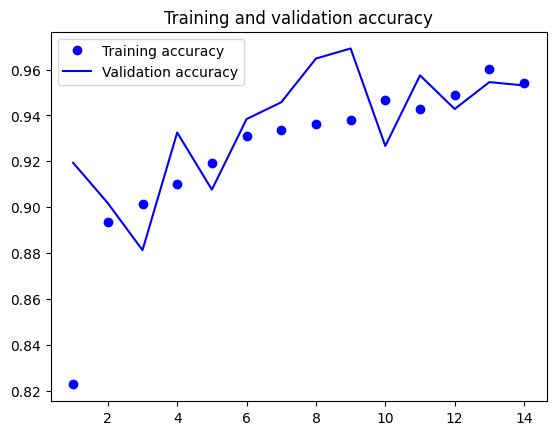

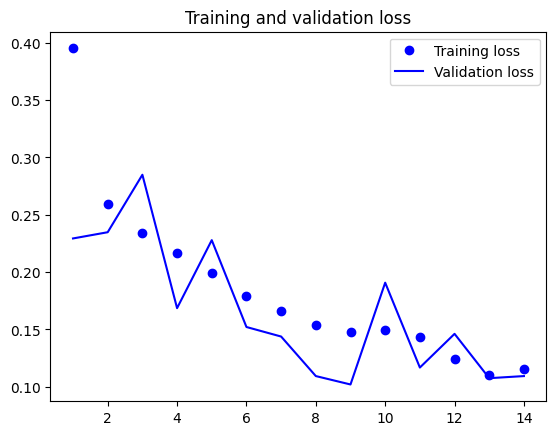

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## 7.Fine-tuning

In [ ]:
base_model.trainable = True  # باز کردن برای fine-tuning

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # یادگیری خیلی کوچک!
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=callbacks
)


Epoch 1/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 83s 412ms/step - accuracy: 0.7374 - loss: 0.6074 - val_accuracy: 0.9413 - val_loss: 0.1536
Epoch 2/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 37s 372ms/step - accuracy: 0.8303 - loss: 0.3711 - val_accuracy: 0.9194 - val_loss: 0.1977
Epoch 3/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 36s 364ms/step - accuracy: 0.8673 - loss: 0.3202 - val_accuracy: 0.9018 - val_loss: 0.2153
Epoch 4/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 44s 397ms/step - accuracy: 0.8843 - loss: 0.2595 - val_accuracy: 0.8974 - val_loss: 0.2249
Epoch 5/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 41s 396ms/step - accuracy: 0.9117 - loss: 0.2180 - val_accuracy: 0.9150 - val_loss: 0.2063


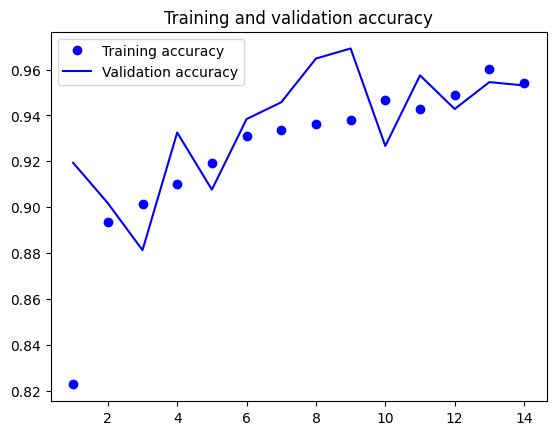

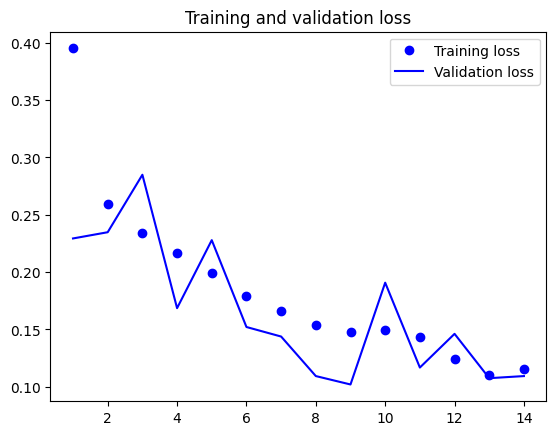

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## Model Evaluation

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 113s 5s/step - accuracy: 0.8947 - loss: 0.2129
Test Accuracy: 0.9074
Test Loss: 0.1990


In [ ]:
import numpy as np

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int).flatten())  # برای binary classification


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


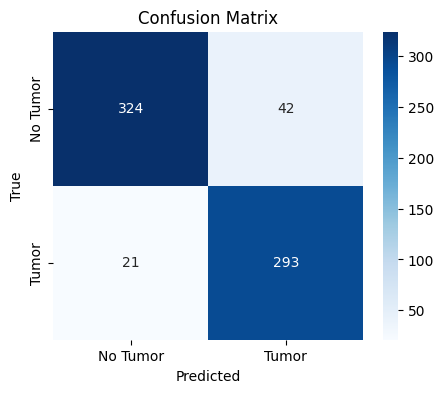

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=['No Tumor', 'Tumor']))


              precision    recall  f1-score   support

    No Tumor       0.94      0.89      0.91       366
       Tumor       0.87      0.93      0.90       314

    accuracy                           0.91       680
   macro avg       0.91      0.91      0.91       680
weighted avg       0.91      0.91      0.91       680



In [ ]:
from tensorflow.keras.preprocessing import image
img1='/content/drive/MyDrive/img3.jpg'
img2='/content/drive/MyDrive/img4.jpg'

img1=image.load_img(img1,target_size=(180,180))
x1=image.img_to_array(img1)
x1=np.expand_dims(x1,axis=0)

img2=image.load_img(img2,target_size=(180,180))
x2=image.img_to_array(img2)
x2=np.expand_dims(x2,axis=0)

pred1= model.predict(x1)
pred2= model.predict(x2)

print(pred1)
print(pred2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
[[0.87058365]]
[[0.15290225]]


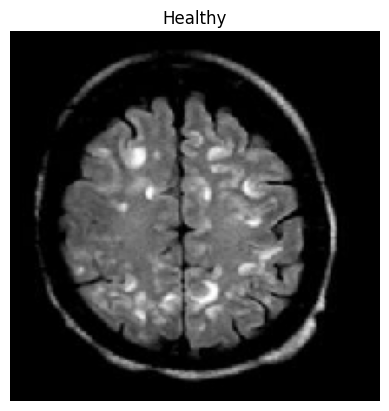

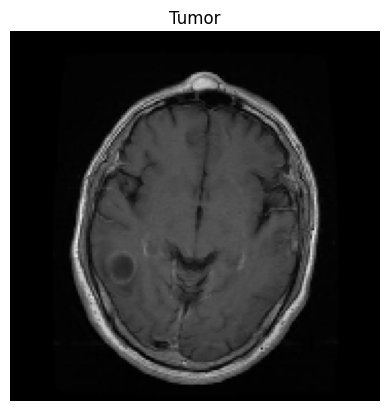

In [ ]:
plt.imshow(img1)
plt.axis('off')
plt.title('Tumor' if pred1<0.5 else 'Healthy')
plt.show()

plt.imshow(img2)
plt.axis('off')
plt.title('Tumor' if pred2<0.5 else 'Healthy')
plt.show()